In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point
from geopandas.tools import overlay


In [2]:
!pip install mapclassify

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Specify the path to your CSV file within your Google Drive
file_path = '/content/drive/My Drive/FM_project/Congressional_Districts.geojson'
gdf = gpd.read_file(file_path)


In [5]:
gdf.head()

,OBJECTID,STATEFP20,GEOID20,CD118FP,NAMELSAD20,LSAD20,CDSESSN,MTFCC20,FUNCSTAT20,ALAND20,...,DISTRICT,STATE,VACANCY,ROOM_NUM,HOB,COMMITTEE_ASSIGNMENTS,LAST_UPDATED,SHAPE_Length,SHAPE_Area,geometry
0,1,01,0101,01,Congressional District 1,C2,118,G5200,N,1.484369e+10,...,01,,0.0,1330.0,LHOB,Appropriations;Natural Resources,2023-11-16 14:34:15+00:00,10.236546,1.615958,"MULTIPOLYGON (((-88.46443 31.69795, -88.46418 ..."
1,2,01,0102,02,Congressional District 2,C2,118,G5200,N,2.695609e+10,...,02,,0.0,1504.0,LHOB,Agriculture;the Judiciary,2023-11-16 14:35:12+00:00,11.518286,2.593391,"MULTIPOLYGON (((-87.42752 31.26274, -87.42750 ..."
2,3,01,0103,03,Congressional District 3,C2,118,G5200,N,2.138139e+10,...,03,,0.0,2469.0,RHOB,Armed Services,2023-01-03 11:34:21+00:00,10.283907,2.117129,"MULTIPOLYGON (((-86.67714 32.89002, -86.67695 ..."
3,4,01,0104,04,Congressional District 4,C2,118,G5200,N,2.280740e+10,...,04,,0.0,266.0,CHOB,Appropriations,2023-01-03 11:34:21+00:00,12.252359,2.293450,"MULTIPOLYGON (((-86.14981 34.53363, -86.14989 ..."
4,5,01,0105,05,Congressional District 5,C2,118,G5200,N,8.697664e+09,...,05,,0.0,1337.0,LHOB,"Armed Services;Homeland Security;Science, Spac...",2023-11-16 14:36:57+00:00,6.158688,0.892792,"MULTIPOLYGON (((-86.15427 34.53026, -86.15425 ..."


Time to begin by exploring the geojson of voting districts

In [6]:
# what does a district look like?
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 444 entries, 0 to 443
Data columns (total 43 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   OBJECTID               444 non-null    int64              
 1   STATEFP20              444 non-null    object             
 2   GEOID20                444 non-null    object             
 3   CD118FP                444 non-null    object             
 4   NAMELSAD20             444 non-null    object             
 5   LSAD20                 444 non-null    object             
 6   CDSESSN                444 non-null    object             
 7   MTFCC20                444 non-null    object             
 8   FUNCSTAT20             444 non-null    object             
 9   ALAND20                444 non-null    float64            
 10  AWATER20               444 non-null    float64            
 11  INTPTLAT20             444 non-null    object     

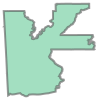

In [7]:
gdf.iloc[0]['geometry']

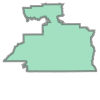

In [8]:
gdf.iloc[1]['geometry']

In [9]:
gdf.iloc[1]

OBJECTID                                                                 2
STATEFP20                                                               01
GEOID20                                                               0102
CD118FP                                                                 02
NAMELSAD20                                        Congressional District 2
LSAD20                                                                  C2
CDSESSN                                                                118
MTFCC20                                                              G5200
FUNCSTAT20                                                               N
ALAND20                                                      26956094151.0
AWATER20                                                       301598922.0
INTPTLAT20                                                     +31.7020846
INTPTLON20                                                    -086.0768417
OFFICE_ID                

In [10]:
gdf['LAST_UPDATED'] = gdf['LAST_UPDATED'].astype(str)

In [11]:
# gdf[gdf['STATEFP20']=='13'].explore()
# states have a few zones are not covered by any congressional district!

### About this data:

"Congressional districts are the 435 areas from which people are elected to the U.S. House of Representatives. This dataset also includes **9 geographies for non-voting at large delegate districts, resident commissioner districts, and congressional districts that are not defined.** After the apportionment of congressional seats among the states based on census population counts, each state is responsible for establishing congressional districts for the purpose of electing representatives. Each congressional district is to be as equal in population to all other congressional districts in a state as practicable. The 118th Congress is seated from January 3, 2023 through January 3, 2025. **In Connecticut, Illinois, and New Hampshire, the Redistricting Data Program (RDP) participant did not define the CDs to cover all of the state or state equivalent area. In these areas with no CDs defined, the code "ZZ" has been assigned, which is treated as a single CD for purposes of data presentation.** The TIGER/Line shapefiles for the District of Columbia, Puerto Rico, and the Island Areas (American Samoa, Guam, the Commonwealth of the Northern Mariana Islands, and the U.S. Virgin Islands) each contain a single record for the non-voting delegate district in these areas. The boundaries of all other congressional districts reflect information provided to the Census Bureau by the states by August 31, 2022."

https://data-usdot.opendata.arcgis.com/datasets/usdot::congressional-districts/about

In [71]:
# lets try to plot the radio stations within a certain 'distance' of the district first
# I will need to read in the csv created in part 1 of this project
file_path = '/content/drive/My Drive/FM_project/FM_stations_labeled.csv'
df = pd.read_csv(file_path)
df.dropna(inplace=True)
df.columns

Index(['Callsign', 'Frequency', 'Service', 'Channel', 'DA or ND',
       'FM Station Class', 'FM Status', 'City', 'State', 'Country',
       'File Number (Application, Construction Permit or License) or Docket Number (Rulemaking)',
       'Effective Radiated Power horizontally',
       'Effective Radiated Power vertically',
       'Antenna Height Above Average Terrain (HAAT) -- horizontal polarization',
       'Antenna Height Above Average Terrain (HAAT) -- vertical polarization',
       'Facility ID Number (unique to each station)', 'Licensee or Permittee',
       'Kilometers distant (radius) from entered latitude, longitude',
       'Miles distant (radius) from entered latitude, longitude',
       'Azimuth, looking from center Lat, Lon to this records Lat, Lon',
       'Antenna Radiation Center Above Mean Sea Level (RCAMSL) - Horizontally Polarized - meters',
       'Antenna Radiation Center Above Mean Sea Level (RCAMSL) - Vertically Polarized - meters',
       'Directional Antenna I

In [13]:
georgia_districts = gdf[gdf['STATEFP20']=='13']
georgia_districts.bounds

,minx,miny,maxx,maxy
117,-82.701050,30.355757,-80.782960,32.378768
118,-85.141931,30.658396,-83.489430,32.887913
119,-85.386581,32.482160,-84.040914,33.906302
120,-84.348525,33.517808,-83.803851,33.970929
121,-84.573432,33.588111,-84.239137,33.947843
122,-84.571683,33.929206,-83.925529,34.617924
123,-84.294048,33.752808,-83.799104,34.090679
124,-84.124275,30.581767,-82.418632,33.202634
125,-84.657098,33.958610,-82.773410,35.001303
126,-84.249245,33.049849,-82.564462,34.295380


### Filtering the stations to those only within a crude measure of a distance will make the correct calculation when projection and other considerations are taken

In [14]:
georgia_districts_buffer = georgia_districts.copy()
georgia_districts_buffer['geometry'] = georgia_districts.buffer(1)

within_bounds_mask = []
for index, row in df.iterrows():
    point = Point(row['lon_decimal'], row['lat_decimal'])
    within_bounds_mask.append(georgia_districts_buffer['geometry'].contains(point))
# Create a list of Point objects for lat/long
geometry = [Point(x) for x in zip(df["lon_decimal"], df["lat_decimal"])]
# Create the GeoDataFrame
geo_df = gpd.GeoDataFrame(df, geometry=geometry, crs=4326)
geo_df.head()

<ipython-input-14-fb105e3388ec>:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  georgia_districts_buffer['geometry'] = georgia_districts.buffer(1)


,Callsign,Frequency,Service,Channel,DA or ND,FM Station Class,FM Status,City,State,Country,...,Directional Antenna ID Number,Directional Antenna Pattern Rotation (degrees),Antenna Structure Registration Number,Height of antenna radiation center above ground level (maximum) (physical center of the antenna),Application ID number (from CDBS database),LMS Application ID,lat_decimal,lon_decimal,commercial,geometry
0,K201CL,88.1 MHz,FX,201,ND,D,LIC,TATITLEK,AK,US,...,31326,-,-,12. m,1364607,a751fb3559f54d08aef5c1b6063ebeb7,60.868333,-146.681722,1,POINT (-146.68172 60.86833)
1,WSJL,88.1 MHz,FM,201,DA,A,LIC,BESSEMER,AL,US,...,13374,0.,1019712,66. m,1564228,4974067c949a4731af1ec1b6063ebeb7,33.395944,-87.018611,1,POINT (-87.01861 33.39594)
2,KBAP,88.1 MHz,FM,201,ND,A,LIC,BATESVILLE,AR,US,...,-,-,-,17. m,1411889,8f5d3abb1cb142f08aefc1b6063ebeb7,35.797833,-91.671250,1,POINT (-91.67125 35.79783)
3,K201ER,88.1 MHz,FX,201,ND,D,LIC,HOLBROOK,AZ,US,...,30889,-,1002376,30. m,492632,95888c9301ea4b3a9fbcc1b6063ebeb7,34.918083,-110.140944,1,POINT (-110.14094 34.91808)
4,KECG,88.1 MHz,FM,201,ND,D,LIC,EL CERRITO,CA,US,...,-,-,-,29. m,1076164,8d79f211f9c44b71bec3c1b6063ebeb7,37.905472,-122.293833,1,POINT (-122.29383 37.90547)


In [15]:
georgia_districts[georgia_districts['CD118FP']=='01'].crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### Now that I have two geodatframes I can overlay them to get the points within an adjustable buffer distance
The buffer distance is arbitrary. It will make the physics applications easier to compute by only calculating signal strengths of towers relatively nearby (even though some may transmitters later be deemed too weak to be heard due to distance related issues inherint in this broadcast format)

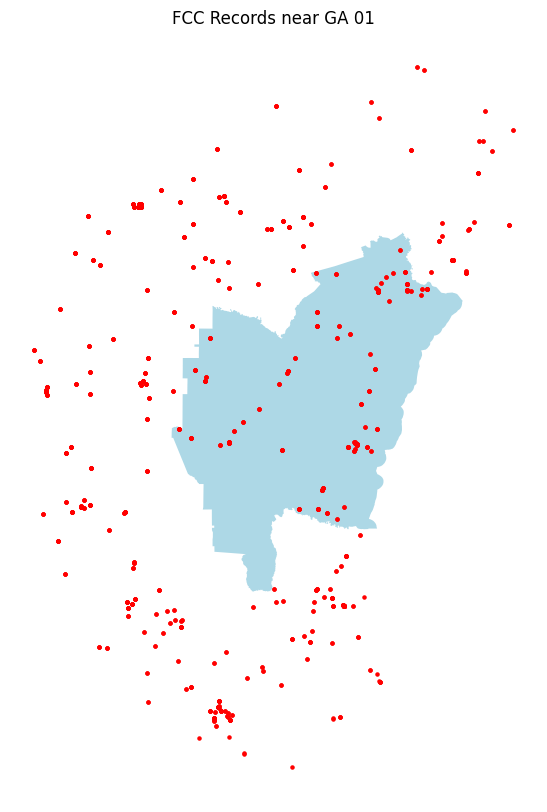

In [25]:
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the radio stations within the first district
# NOTE: OVERLAY returns a new geodf that contains all the columns of each.
stations_within_district = overlay(geo_df.iloc[within_bounds_mask],gpd.GeoDataFrame(georgia_districts_buffer[georgia_districts_buffer['CD118FP']=='01'], geometry =georgia_districts_buffer[georgia_districts_buffer['CD118FP']=='01']['geometry']), how="intersection")
georgia_districts[georgia_districts['CD118FP']=='01'].plot(ax=ax, color = 'lightblue')
stations_within_district.drop(columns=list(georgia_districts_buffer.columns)[:-1], inplace = True) # there must be a better way than this but it works...
stations_within_district.plot(ax=ax, color="red", markersize=5)
# Set the axis off and show the plot
ax.set_axis_off()
plt.title('FCC Records near GA 01' )
plt.show()


In [17]:
stations_within_district['Channel'].value_counts()

279    27
248    24
254    24
258    22
285    22
       ..
289     4
262     4
269     3
296     3
278     2
Name: Channel, Length: 99, dtype: int64

In [102]:
# pick a channel and see the location of fcc records nearcy
channel = 245
frequency = stations_within_district[stations_within_district['Channel']==channel]['Frequency'].value_counts().keys()[0]
district = georgia_districts['CD118FP'].values[11]
frequency , district

('96.9  MHz', '13')

''

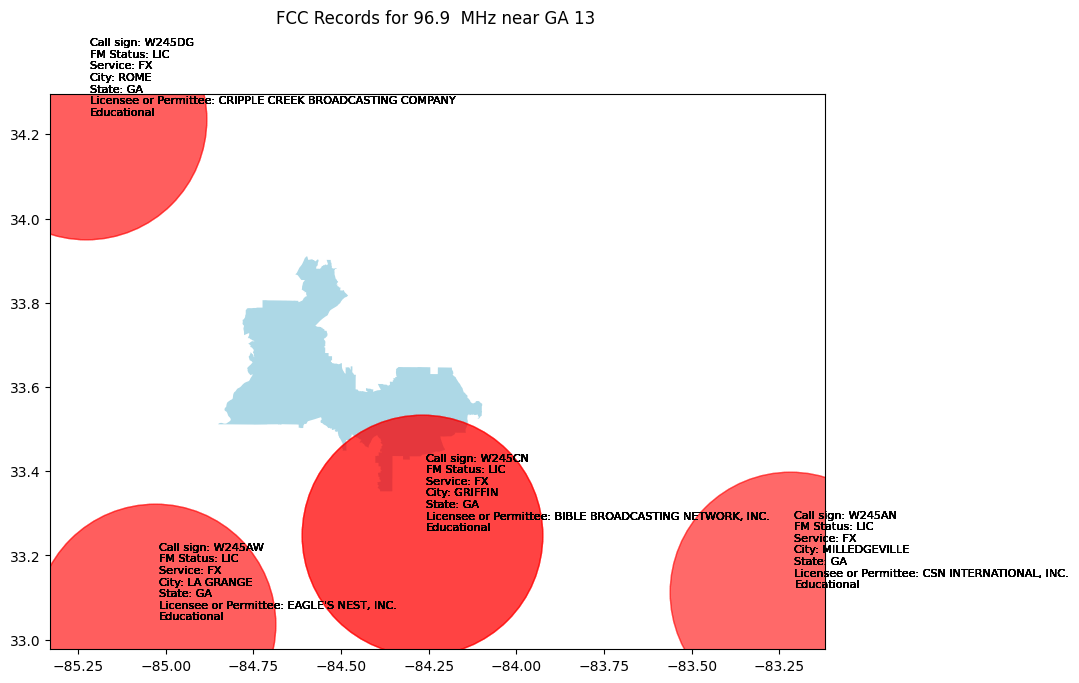

In [103]:

fig, ax = plt.subplots(figsize=(10, 10))

# Plot the radio stations within the first district
# NOTE: OVERLAY returns a new geodf that contains all the columns of each.
stations_within_district = overlay(geo_df.iloc[within_bounds_mask],
                                   gpd.GeoDataFrame(georgia_districts_buffer[georgia_districts_buffer['CD118FP']==district],
                                      geometry =georgia_districts_buffer[georgia_districts_buffer['CD118FP']==district]['geometry']), how="intersection")
georgia_districts[georgia_districts['CD118FP']==district].plot(ax=ax, color = 'lightblue')
stations_within_district.drop(columns=list(georgia_districts_buffer.columns)[:-1], inplace = True) # there must be a better way than this but it works...
stations_within_district[stations_within_district['Channel']==channel].plot(ax=ax, color="red", markersize=30000, alpha=.1)
# stations_within_district[stations_within_district['Channel']==270].plot(ax=ax, color="purple", markersize=5)
# Set the axis off and show the plot
# ax.set_axis_off()
plt.title(f'FCC Records for {frequency} near GA {district} \n \n \n')

for _, row in stations_within_district[stations_within_district['Channel'] == channel].iterrows():
    ax.annotate(f"Call sign: {row['Callsign']}\nFM Status: {row['FM Status']}\nService: {row['Service']}\nCity: {row['City']}\nState: {row['State']}\nLicensee or Permittee: {row['Licensee or Permittee']}\n{ np.where(row['commercial']==1, 'Commercial','Educational')   }",
                xy=(row.geometry.x, row.geometry.y),  # Position of the annotation
                xytext=(3, 3),  # Offset text slightly
                textcoords="offset points",
                fontsize=8,
                color='black')

;

In [19]:
## This test appears to work! Later I plan to use distance, power, and basic height information to infer which stations are dominant for specific locations for each of the available channels.

In [20]:
georgia_districts_buffer.reset_index(drop = True, inplace=True)
georgia_districts.reset_index(drop = True, inplace=True)

In [21]:
import matplotlib.colors as mcolors

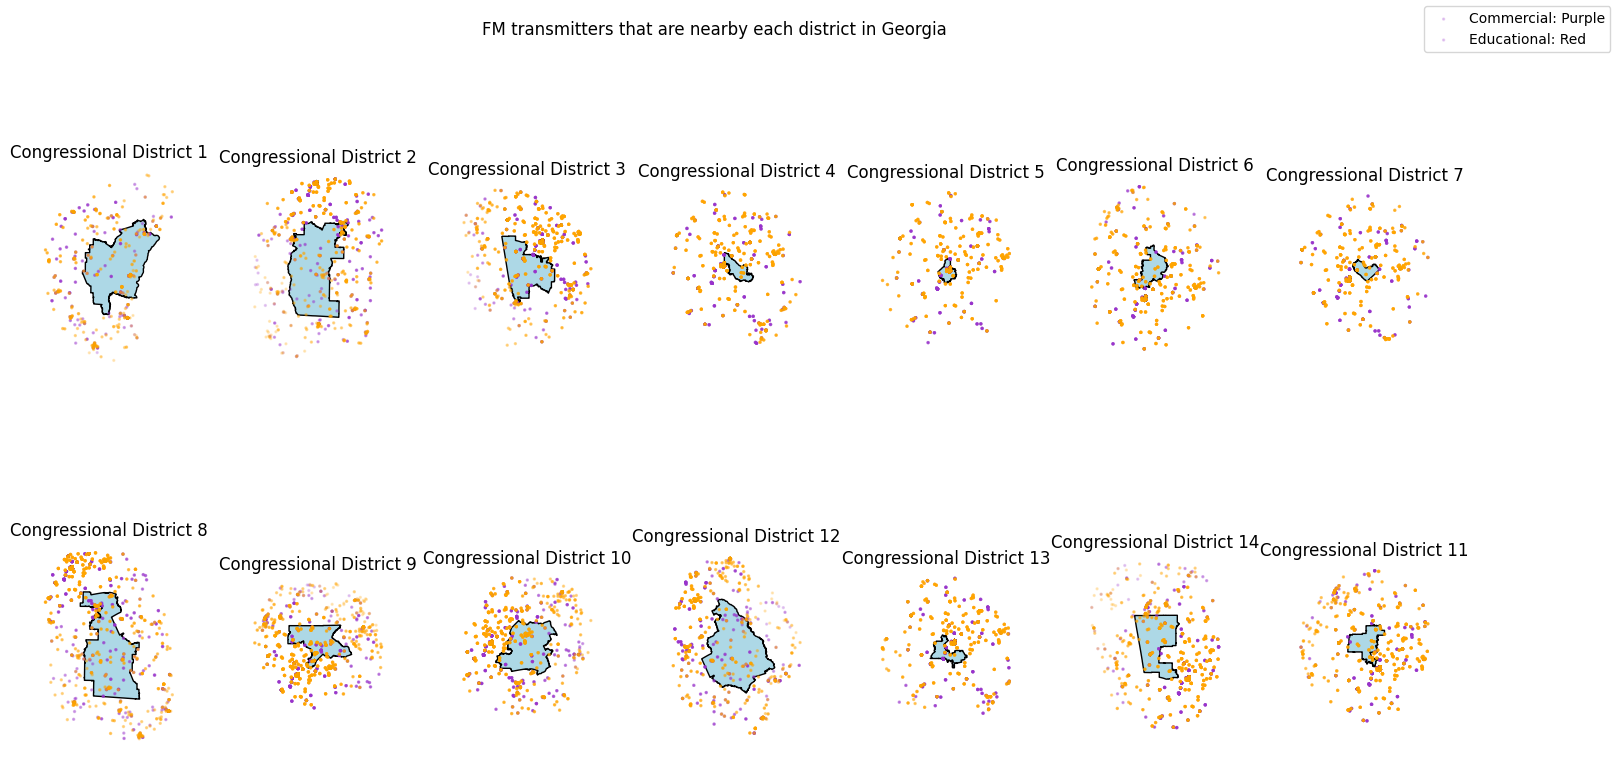

In [22]:
# Create the subplots with adjusted spacing
fig, axes = plt.subplots(2, 7, figsize=(18, 9))
fig.subplots_adjust( wspace=0.5)

# Create a custom color map
colors = ['orange', 'darkorchid']
cmap = mcolors.ListedColormap(colors)

# Iterate over each district
for i, row in georgia_districts.iterrows():
    ax = axes.flat[i]

    stations_within_district = overlay(geo_df.iloc[within_bounds_mask],gpd.GeoDataFrame(georgia_districts_buffer[georgia_districts_buffer['CD118FP']==row['CD118FP']],
                                                                                        geometry =georgia_districts_buffer[georgia_districts_buffer['CD118FP']==row['CD118FP']]['geometry']), how="intersection")
    # Plot the district and stations, color by 'commercial' column
    gpd.GeoDataFrame(georgia_districts[georgia_districts['CD118FP']==row['CD118FP']],
                     geometry =georgia_districts[georgia_districts['CD118FP']==row['CD118FP']]['geometry']).plot(ax=ax, color = 'lightblue',edgecolor='black', linewidth=1)
    stations_within_district.drop(columns=list(georgia_districts_buffer.columns)[:-1], inplace = True) # there must be a better way than this but it works...
    stations_within_district.plot(ax=ax, column='commercial', markersize=2, alpha=0.2, legend=False, cmap=cmap)  # Color by 'commercial' column

    # Set the axis off
    ax.set_axis_off()

    # Add title for each subplot
    ax.set_title(row['NAMELSAD20'])

# Set the figure title
fig.suptitle('FM transmitters that are nearby each district in Georgia')
fig.legend(['Commercial: Purple', 'Educational: Red'])# verify this!
# Show the plot
plt.show()

In [23]:
###

### Project status:
The visuals above represent all FCC **records** in locations labeled Educational or Commercial. Each channel can, in theory, be analyzed as a group for the chosen location to assess the dominance or intereference between two transmiters on the same frequency (channel).

